In [7]:
# %% [markdown]
# # Yield Prediction with Random Forest and XGBoost
# 
# Using `prediction_yield_new2.csv` to predict agricultural yield.
# 
# **Goal:**  
# Build supervised learning models (RF and XGBoost) to predict `yield` with
# low **MSE**, **MSAE**, and **MAE**.
# 
# We will:
# - Load and explore the dataset
# - Preprocess numerical and categorical features
# - Train/test split
# - Train Random Forest and XGBoost
# - Evaluate using MAE, MSE, MSAE
# - Show feature importances
# - Plot Actual vs Predicted
# - Export predictions from the best model to CSV

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

# If xgboost is not installed, run: pip install xgboost
from xgboost import XGBRegressor

# For nice tables
pd.set_option("display.max_columns", None)

# %% [markdown]
# ## 1. Load Data & Basic Understanding

# %%
# Adjust the path if needed
df = pd.read_csv('prediction yield_new2.csv')
print("Shape of data:", df.shape)
df.head()

# %%
# Quick info about dtypes and missing values
df.info()

# %%
# Basic descriptive statistics for numerical columns
df.describe().T


Shape of data: (28242, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
 8   fertilizer_kg/ha               28242 non-null  float64
 9   solar_radiation_MJ/m^2-day)    28242 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.2+ MB


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,28242.0,14120.500000,8152.907488,0.00,7060.250000,14120.50000,21180.750000,28241.000000
Year,28242.0,2001.544296,7.051905,1990.00,1995.000000,2001.00000,2008.000000,2013.000000
hg/ha_yield,28242.0,77053.332094,84956.612897,50.00,19919.250000,38295.00000,104676.750000,501412.000000
average_rain_fall_mm_per_year,28242.0,910.865089,665.120536,0.20,396.880000,826.12000,1322.670000,4653.110000
pesticides_tonnes,28242.0,37076.909344,59958.784665,0.04,1702.000000,17529.44000,48687.880000,367778.000000
avg_temp,28242.0,20.542627,6.312051,1.30,16.702500,21.51000,26.000000,30.650000
fertilizer_kg/ha,28242.0,129.215624,168.075721,0.00,56.814815,96.10596,156.495698,2299.420938
solar_radiation_MJ/m^2-day),28242.0,18.276338,3.263133,7.39,16.830000,19.10000,20.290000,24.030000


X shape: (28242, 9)
y shape: (28242,)
Numeric columns: ['Unnamed: 0', 'Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m^2-day)']
Categorical columns: ['Area', 'Item']
Train size: (22593, 9) Test size: (5649, 9)
Random Forest:
  Train - MAE: 1282.9287, MSE: 13434941.4179, MSAE: 13434941.4179
  Test  - MAE: 3498.7368, MSE: 95800751.2452, MSAE: 95800751.2452
XGBoost:
  Train - MAE: 6690.8892, MSE: 107710272.0000, MSAE: 107710270.7709
  Test  - MAE: 7942.7861, MSE: 181016272.0000, MSAE: 181016267.2035

Top 20 features for Random Forest:


,feature,importance
111,cat__Item_Potatoes,0.369188
108,cat__Item_Cassava,0.102402
115,cat__Item_Sweet potatoes,0.086582
5,num__fertilizer_kg/ha,0.058496
49,cat__Area_India,0.058234
6,num__solar_radiation_MJ/m^2-day),0.049918
3,num__pesticides_tonnes,0.045716
4,num__avg_temp,0.036948
0,num__Unnamed: 0,0.034383
117,cat__Item_Yams,0.027497



Top 20 features for XGBoost:


,feature,importance
49,cat__Area_India,0.167984
111,cat__Item_Potatoes,0.092386
108,cat__Item_Cassava,0.066787
12,cat__Area_Australia,0.052930
55,cat__Area_Japan,0.041908
115,cat__Item_Sweet potatoes,0.025964
69,cat__Area_Mexico,0.025289
117,cat__Item_Yams,0.024507
21,cat__Area_Brazil,0.021463
34,cat__Area_Egypt,0.019127


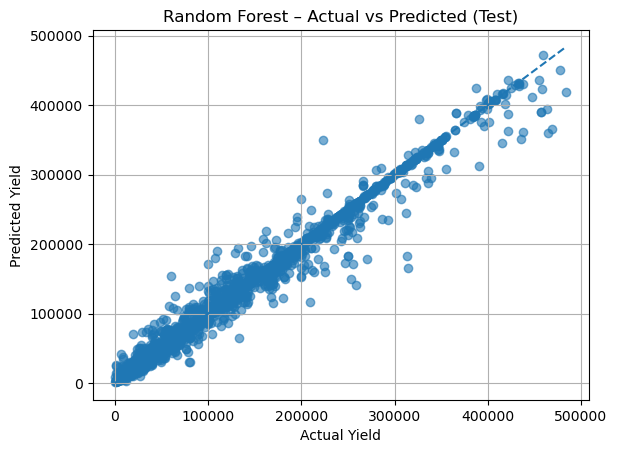

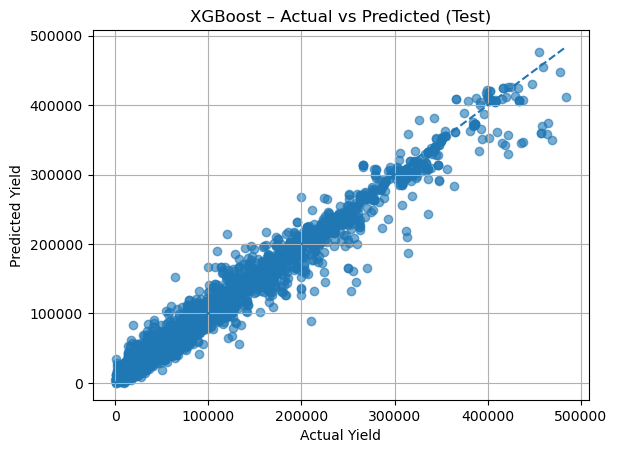

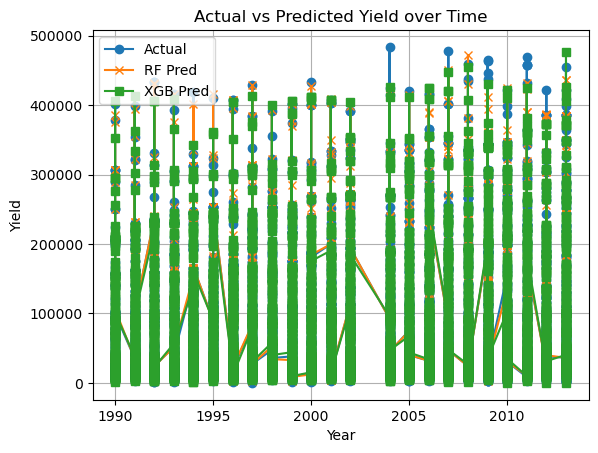

Best model based on MAE_test: Random Forest
Predictions exported to: yield_predictions_best_model.csv


: 

In [ ]:

# %% [markdown]
# ### Identify Target and Features
# 
# Here we assume the target column is named `"yield"`.  
# If your file uses a different name (e.g., `"Yield_kg_ha"`), change it below.

# %%
target_col = "hg/ha_yield"   # 🔴 CHANGE HERE if your target has a different name

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in df.columns: {df.columns.tolist()}")

y = df[target_col]
X = df.drop(columns=[target_col])

print("X shape:", X.shape)
print("y shape:", y.shape)

# %%
# Detect categorical vs numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# %% [markdown]
# ## 2. Train–Test Split
# 
# If the data is time-dependent, you may want to **sort by year/date** and use
# the earliest part for training and the latest for testing.
# 
# For now, we use a random 80/20 split.

# %%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# %% [markdown]
# ## 3. Preprocessing Pipelines
# 
# - Numerical: impute missing values (median)
# - Categorical: impute missing (most frequent) + one-hot encode

# %%
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        # Tree-based models don't need scaling, so we skip StandardScaler
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

# %% [markdown]
# ## 4. Define Metrics (MAE, MSE, MSAE)
# 
# **Note:**  
# MSAE is not a standard metric name. Here, we define:
# 
# \[
# \text{MSAE} = \text{mean}(|y_{\text{true}} - y_{\text{pred}}|^2)
# \]
# 
# Mathematically this equals MSE, but we keep it separate to match the assignment.
# If your instructor defines MSAE differently, adjust the function.

# %%
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    msae = np.mean(np.abs(y_true - y_pred) ** 2)  # adjust if your course uses a different formula
    return mae, mse, msae

# %% [markdown]
# ## 5. Model 1 – Random Forest

# %%
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)

rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf_model),
    ]
)

# Train RF
rf_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_pipeline.predict(X_train)
y_test_pred_rf = rf_pipeline.predict(X_test)

rf_mae_train, rf_mse_train, rf_msae_train = compute_metrics(y_train, y_train_pred_rf)
rf_mae_test, rf_mse_test, rf_msae_test = compute_metrics(y_test, y_test_pred_rf)

print("Random Forest:")
print("  Train - MAE: {:.4f}, MSE: {:.4f}, MSAE: {:.4f}".format(rf_mae_train, rf_mse_train, rf_msae_train))
print("  Test  - MAE: {:.4f}, MSE: {:.4f}, MSAE: {:.4f}".format(rf_mae_test, rf_mse_test, rf_msae_test))

# %% [markdown]
# ## 6. Model 2 – XGBoost

# %%
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", xgb_model),
    ]
)

# Train XGB
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_pipeline.predict(X_train)
y_test_pred_xgb = xgb_pipeline.predict(X_test)

xgb_mae_train, xgb_mse_train, xgb_msae_train = compute_metrics(y_train, y_train_pred_xgb)
xgb_mae_test, xgb_mse_test, xgb_msae_test = compute_metrics(y_test, y_test_pred_xgb)

print("XGBoost:")
print("  Train - MAE: {:.4f}, MSE: {:.4f}, MSAE: {:.4f}".format(xgb_mae_train, xgb_mse_train, xgb_msae_train))
print("  Test  - MAE: {:.4f}, MSE: {:.4f}, MSAE: {:.4f}".format(xgb_mae_test, xgb_mse_test, xgb_msae_test))

# %% [markdown]
# ## 7. Evaluation Table – RF vs XGBoost

# %%
results = pd.DataFrame(
    {
        "model": ["Random Forest", "XGBoost"],
        "MAE_train": [rf_mae_train, xgb_mae_train],
        "MSE_train": [rf_mse_train, xgb_mse_train],
        "MSAE_train": [rf_msae_train, xgb_msae_train],
        "MAE_test": [rf_mae_test, xgb_mae_test],
        "MSE_test": [rf_mse_test, xgb_mse_test],
        "MSAE_test": [rf_msae_test, xgb_msae_test],
    }
)

results

# %% [markdown]
# ## 8. Feature Importance
# 
# We extract feature importances from the trained models and map them back to
# the transformed feature names (after one-hot encoding).

# %%
def get_feature_importance(pipeline, model_name, top_n=20):
    """
    Extract feature importances from a fitted pipeline with a tree-based model.
    """
    # Get the preprocessor and model
    preprocessor = pipeline.named_steps["preprocessor"]
    model = pipeline.named_steps["model"]
    
    # Get feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out()
    
    importances = model.feature_importances_
    fi_df = pd.DataFrame(
        {"feature": feature_names, "importance": importances}
    ).sort_values("importance", ascending=False)
    
    print(f"\nTop {top_n} features for {model_name}:")
    display(fi_df.head(top_n))
    return fi_df

fi_rf = get_feature_importance(rf_pipeline, "Random Forest", top_n=20)
fi_xgb = get_feature_importance(xgb_pipeline, "XGBoost", top_n=20)

# %% [markdown]
# ## 9. Actual vs Predicted Plots

# %%
def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_actual_vs_predicted(y_test, y_test_pred_rf, "Random Forest – Actual vs Predicted (Test)")
plot_actual_vs_predicted(y_test, y_test_pred_xgb, "XGBoost – Actual vs Predicted (Test)")

# %% [markdown]
# ## 10. Optional Time-Series Plot
# 
# If the dataset is chronological (e.g., has a `"year"` or `"date"` column), we
# can plot actual vs predicted yield over time.
# 
# This code tries `"year"` first; adjust the column name if needed.

# %%
time_col_candidates = ["year", "Year", "date", "Date"]
time_col = None
for c in time_col_candidates:
    if c in X_test.columns:
        time_col = c
        break

if time_col is not None:
    # Rebuild a test dataframe with index aligned
    test_df = X_test.copy()
    test_df["actual_yield"] = y_test
    test_df["pred_rf"] = y_test_pred_rf
    test_df["pred_xgb"] = y_test_pred_xgb
    
    test_df_sorted = test_df.sort_values(by=time_col)
    
    plt.figure()
    plt.plot(test_df_sorted[time_col], test_df_sorted["actual_yield"], label="Actual", marker="o")
    plt.plot(test_df_sorted[time_col], test_df_sorted["pred_rf"], label="RF Pred", marker="x")
    plt.plot(test_df_sorted[time_col], test_df_sorted["pred_xgb"], label="XGB Pred", marker="s")
    plt.xlabel(time_col)
    plt.ylabel("Yield")
    plt.title("Actual vs Predicted Yield over Time")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No time column (year/date) detected – skipping time-series plot.")

# %% [markdown]
# ## 11. Select Best Model & Export Predictions
# 
# The best model is the one with the **lowest MAE, MSE, and MSAE** on the test set
# (you can prioritize based on MAE or MSE depending on your assignment).

# %%
# Choose best model based on MAE_test (you can change to MSE_test if preferred)
best_idx = results["MAE_test"].idxmin()
best_model_name = results.loc[best_idx, "model"]
print("Best model based on MAE_test:", best_model_name)

if best_model_name == "Random Forest":
    best_pipeline = rf_pipeline
    best_pred = y_test_pred_rf
else:
    best_pipeline = xgb_pipeline
    best_pred = y_test_pred_xgb

# Build a DataFrame for export
export_df = X_test.copy()
export_df[target_col] = y_test
export_df["predicted_yield"] = best_pred
export_df["model_used"] = best_model_name

export_path = "yield_predictions_best_model.csv"
export_df.to_csv(export_path, index=False)
print(f"Predictions exported to: {export_path}")

# %% [markdown]
# ## 12. Final Summary (Write-Up)
# 
# In a markdown cell of your notebook, summarize:
# - Which model performed best (RF vs XGBoost)
# - Test set metrics (MAE, MSE, MSAE) for both models
# - Whether there is overfitting (compare train vs test errors)
# - Which features were most important, and how they relate to yield
# - Whether the goal of **low MSE, MSAE, and MAE** was achieved
